# Делаем простой классификатор P300

Мой коллега Рафаэль Григорян [недавно написал](https://m.habr.com/ru/post/479164/) статью о том, зачем человечеству потребовалась ЭЭГ и какие значимые явления могут быть зарегистрированы в ней. Сегодня в продолжение темы нейроинтерфейсов мы используем один из открытых датасетов, записанных на игре, использующей механику P300, чтобы визуализировать сигнал ЭЭГ, посмотреть структуру вызванных потеницалов, построить основные классификаторы, оценить качество, с которым мы можем предсказать наличие такого вызыванного потенциала.

Напомню, что P300 - это вызванный потенциал (ВП), специфический отклик мозга связанный с принятием решений и и различением стимулов (что он из себя представляет мы увидим ниже). Обычно он используется для построения современных BCI.

Для того, чтобы заняться классификацией ЭЭГ, можно позвать друзей, написать [игру про Енотов и Демонов в VR](https://impulse-neiry.com/#rec124575598), записать собственные реакции и написать научную статью (об этом я расскажу как-нибудь в другой раз), но по счастью, учёные со всего мира уже провели некоторые эксперименты за нас и осталось только скачать данные.

Разбор способа построения нейроинтерфейса на P300 с пошаговым кодом и визуализациями, а также ссылку на репозиторий можно найти под катом.

---

С точки зрения ЭЭГ P300 это всего лишь всплеск в определённое время в определённых каналах. Способов вызвать его известно множество, например, если концентрироваться на одном предмете, а он в случайный момент активируется (изменит форму, цвет, яркость или отпрыгнет куда-то). Вот как это было реализовано в стародавние времена

[![P300 old interface](http://img.youtube.com/vi/wKDimrzvwYA/0.jpg)](https://www.youtube.com/watch?v=wKDimrzvwYA)

В общем виде схема следующая: в поле зрения человека есть несколько (обычно от 3 до 7) стимулов. Человек выбирает один из них и сосредотачивается на нём (хороший способ - считать количество активаций), далее каждый объект мигает в случайном порядке. Зная время активации каждого стимула мы теперь можем посмотреть на следующую за этим ЭЭГ и установить, был ли в ней характерый пик (мы увидим его на визуализациях ниже). Поскольку человек концентрировался только на одном стимуле, то и пик должен быть один. Таким образом в этих ваших нейроинтерфейсах происходит выбор одного из нескольких вариантов (букв для написания, действий в игре и Бог знает чего ещё). Если вариантов больше семи, можно положить их на сетку и свести задачу к выбору строки+столбца. Так получился классический матричный P300 speller, показанный выше.

В случае датасета, рассматриваемого сегодня, визуальная часть (как и название) была позаимствованы у известной игры [space inviders](https://en.wikipedia.org/wiki/Space_Invaders). Выглядело это примерно так

![Brain Inviders gameplay](images/brain_inviders.png)

По-сути, это тот же спеллер, только буквы заменены на игровых инопланетян.
Также сохранилось [видео процесса игры](https://www.youtube.com/watch?v=s73l8ZfQcWw) и [технические отчёты](https://arxiv.org/ftp/arxiv/papers/1905/1905.05182.pdf)

Так или иначе, в интернете появились данные, собранные с помощью этой игры и мы можем получить к ним доступ. Данные состоят из 16 каналов ЭЭГ и одного канала событий, показывающего в какие моменты были активированы целевой (загаданный игроком), и нецелевые стимулы, с ними мы и будем работать.

Большинство датасетов для BCI было записано нейрофизиологами, а это ребята, которые не очень заботятся о совместимости, поэтому форматы данных отличаются большим разнообразием: от разных версий `.mat` файлов до "стандартных" форматов [`.edf`](https://en.wikipedia.org/wiki/European_Data_Format) и [`.gdf`](https://en.wikipedia.org/wiki/General_Data_Format_for_Biomedical_Signals).
Самое главное, что нужно знать про эти форматы - вы не хотите их парсить или работать с ними напрямую.
По счастью группа энтузиастов из [NeuroTechX](https://neurotechx.com/) написала загрузчики для некоторых датасетов напрямую в numpy.
Эти загрузчики являются частью проекта [moabb](https://github.com/NeuroTechX/moabb/tree/master/moabb) претендующего на универсализацию решений для BCI.

## Загрузка сырого датасета

In [1]:
from pathlib import Path
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import moabb.datasets

In [2]:
matplotlib.style.use('seaborn')
plt.rcParams.update({'font.size': 15})

In [3]:
sampling_rate = 512

m_dataset = moabb.datasets.bi2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)

__Осторожно: загрузка ~7.5 Гб__, придётся подождать

У метода `download` есть параметр пути загрузки, но он, по-видимому, не работает, так что данные будут храниться в `~/mne_data`

In [ ]:
m_dataset.download()

In [ ]:
m_data = m_dataset.get_data()

На данном этапе мы получили структуру [RawEDF](https://mne.tools/stable/generated/mne.io.Raw.html), содержащую записи ЭЭГ. Это структура из пакета [`mne`](https://mne.tools/stable/index.html), им обычно пользуются биологи для взаимодействия с сигналами: в этой структуре есть встроенные методы для фильтрации, визуализации, хранения меток и мало ли чего ещё. Но мы не будем идти этим путём т.к. интерфейс пакета имеет свойство быть нестабильным (текущая версия `0.19`, но мы будем использовать `0.17` т.к. датасет уже не читается новой версией) и слабо документированным, через это наши результаты могут стать невоспроизводимыми.

Что мы возьмём из полученной структуры - это метки каналов в [системе 10-20](https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)). Это международная схема расположения электродов на голове человека, созданная для того, чтобы учёные могли соотносить зоны мозга и расположения каналов ЭЭГ. Ниже приведено расположение электродов в системе 10-10 (отличается от 10-20 вдвое большей плотностью разметки) и красным отмечены те каналы, которые были записаны в этом датасете.
![система 10-10](images/10-10_system.jpg)

In [6]:
print(m_data[1]['session_1']['run_1'])
channels = m_data[1]['session_1']['run_1'].ch_names[:-1]
channels

<RawEDF  |  1.gdf, n_channels x n_times : 17 x 159232 (311.0 sec), ~20.7 MB, data loaded>


['FP1',
 'FP2',
 'F5',
 'AFz',
 'F6',
 'T7',
 'Cz',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'Oz',
 'O2']

Сначала мы из загруженных данных для каждого испытуемого выделяем массивы непрерывного ЭЭГ по 16 секунд и все метки для этого промежутка (в данных это просто ещё один канал, в котором отмечены начала интересующих нас событий).

На данном этапе мы сохраняем максимальную длину непрерывного ЭЭГ для того, чтобы при дальнейшей фильтрации не встречаться с краевыми эффектами.

In [7]:
raw_dataset = []

for _, sessions in sorted(m_data.items()):
    eegs, markers = [], []
    for item, run in sorted(sessions['session_1'].items()):
        data = run.get_data()
        eegs.append(data[:-1])
        markers.append(data[-1])
    raw_dataset.append((eegs, markers))

In [8]:
raw_sample = raw_dataset[0][0][0]

In [9]:
len(raw_dataset), len(raw_dataset[0]), len(raw_dataset[0][0]), raw_dataset[0][0][0].shape

(24, 2, 4, (16, 159232))

Датасет из MOABB нам более не потребуется, поэтому мы улалим его чтобы отчистить память

In [10]:
del m_data, m_dataset

## Фильтрация и разделение на эпохи

В целом для обзора методов предобработки и классификации ЭЭГ могу порекомендовать [отличный обзор](https://iopscience.iop.org/article/10.1088/1741-2552/aab2f2/meta) от мэтров нейрокомпьютерных интерфейсов. Также не очень давно вышел более [свежий обзор](https://iopscience.iop.org/article/10.1088/1741-2552/ab0ab5) нейросетевых метедов. Взглянем на типичный пайплайн обработки данных в BCI

![typical eeg processing pipeline](images/eeg_pipeline.jpg)

Минимальная предобработка сигнала ЭЭГ для классификации включает 3 шага:
- децимация
- фильтрация
- масштабирование

Для реализации этих шагов мы воспользуемся старым добрым `sklearn`-ом и его парадигмой трансформеров и пайплайнов для того, чтобы наш препроцессинг мог быть легко расширяемым.
Код трансформеров вынесен в отдельный файл, ниже опишем некоторые детали.

__Децимация__

Почему-то в некоторых статьях и примерах обаработки я встречал понижение частоты сигнала простым выкидыванием отсчётов в стиле `eeg = eeg[:, ::10]`. Это совершенно некорректно (почему - см. любую книжку по обработке сигналов). Мы используем стандартную [реализацию из `scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html).

__Фильтрация__

Здесь мы также опираемся на фильтры из `scipy`, выбрав bandpass фильтр Баттерворта 4 порядка и применив его в прямом и обратном направлении ([`filtfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html)) для сохранения фазы. Частоты отсечки - от 0.5 до 20 Гц, это стандартный диапазон для нашей задачи.

__Масштабирование__

Мы использовали поканальный `StandardScaler` (вычитает среднее, делит на стандартное отклонение), который видит все сигналы из выборки. На самом деле в этом месте вводится небольшая утечка данных т.к. формально, скейлер видит данные и из тестовой выборки, но при достаточно больших объёмах данных среднее и отклонение оказываются одинаковыми.
Мастабирование производится поканально для того, чтобы можно было в рамках одного датасета агрегировать данные с разных датчиков, имеющих разные порядки величин и природу (например, [кожно-гальваническую реакцию (КГР)](https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%BA%D0%BE%D0%B6%D0%B8))

Кроме приведённых операций можно было также выделить артифакты в ЭЭГ (моргания, жевательные движения, движения головы), но этот датасет уже очень чистый, так что оставим это до следующего раза.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import transformers

In [12]:
reload(transformers)

decimation_factor = 10
final_rate = sampling_rate // decimation_factor
epoch_duration = 0.9 # seconds
labels_mapping = {33285.: 1, 33286.: 0}
captions = {0: 'empty', 1: 'target'}

eeg_pipe = make_pipeline(
    transformers.Decimator(decimation_factor),
    transformers.ButterFilter(sampling_rate // decimation_factor, 4, 0.5, 20),
    transformers.ChannellwiseScaler(StandardScaler()),
)
markers_pipe = transformers.MarkersTransformer(labels_mapping, decimation_factor)

Далее мы применим пайплайн препроцессинга к нашим данным и порежем непрерывный сигнал ЭЭГ на эпохи. Будем называть эпохой промежуток времени сразу после активации стимула с характерной продолжительностью 0.5-1 секунды, в нашем случае продолжительность составляет 900 мс, хотя её можно и сократить.

В нашем датасете 16 каналов ЭЭГ, после применения децимации частота понизится до 50 Гц, таким образом одна эпоха будет описываться матрицей `(16, 45)` - 900 мс на 50 Гц это 45 временных отсчётов.

Метки в данном датасете только бинарыне - они маркируют целевой (загаданный игроком, активный, 1) и не целевой (пустой, 0) сигнал.

In [13]:
for eegs, _ in raw_dataset:
    eeg_pipe.fit(eegs)

In [14]:
dataset = []
epoch_count = int(epoch_duration * final_rate)

for eegs, markers in raw_dataset:
    epochs = []
    labels = []
    filtered = eeg_pipe.transform(eegs)
    markups = markers_pipe.transform(markers)
    for signal, markup in zip(filtered, markups):
        epochs.extend([signal[:, start:(start + epoch_count)] for start in markup[:, 0]])
        labels.extend(markup[:, 1])
    dataset.append((np.array(epochs), np.array(labels)))

In [15]:
dataset[0][0].shape, dataset[0][0].dtype, dataset[0][1].shape

((1308, 16, 45), dtype('float64'), (1308,))

Таким образом у нас получился датасет в стиле `Pytorch` в котором первый индекс отсчитывает различных людей. С такой структурой мы можем как провести кросс-валидацию внутри данных одного человека, так и протестировать переносимость классификатора между разными людьми (т.н. transfer learning, calibration-less prediction). Данные одного человека состоят из массива эпох и меток классов. Количество эпох у каждого человека немного разнится в силу особенностей записи.

На данном этапе `raw_dataset` больше нам не понадобится, так что мы его удалим для освобождения памяти

In [16]:
del raw_dataset

## Исследование и визуализация данных

Для начала взглянем на один из непрерывных сигналов до нарезки на эпохи.

Не смотря на то, что он уже отфильтрован, на нём не видно глазом каких-либо активаций и больше походит на какой-то шум.

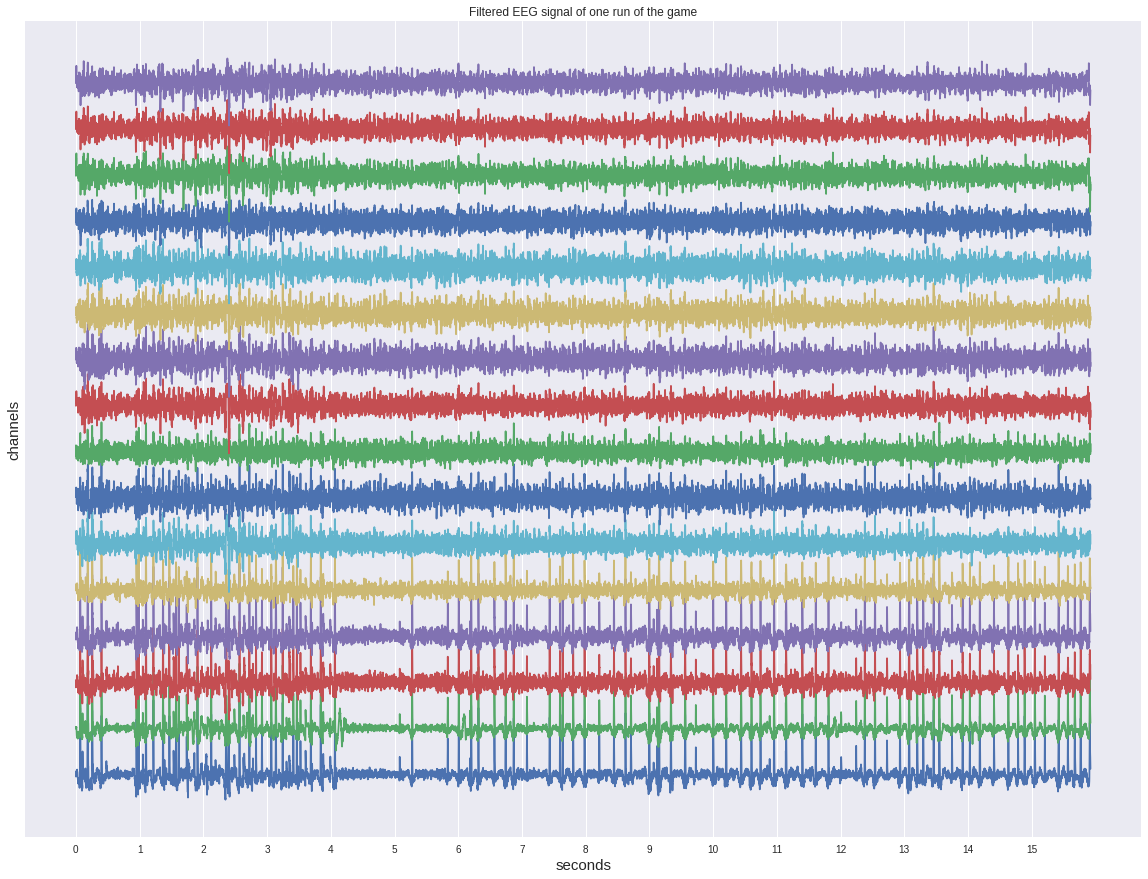

In [17]:
epoch = eeg_pipe.fit_transform([raw_sample])[0]
plt.figure(figsize=(20, 15))
plt.plot(epoch.T + np.arange(len(epoch))*5)
plt.yticks([])
plt.xticks(np.arange(0, 16000, 1000), np.arange(0, 32, 1))
plt.xlabel('seconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.title('Filtered EEG signal of one run of the game')
plt.show()

Если же мы рассмотрим только одну целевую эпоху из нашего датасета, то увидим характерный подъём на промежутке 400-600 мс. Это и есть наш искомый вызванный потенциал P300.

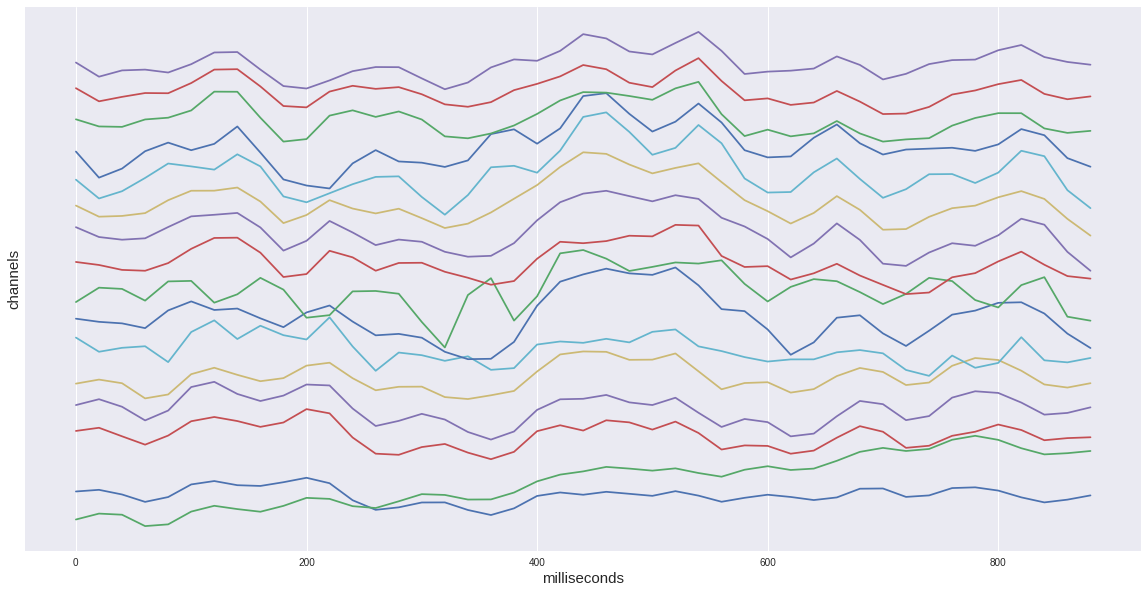

In [18]:
epoch = dataset[0][0][0]
plt.figure(figsize=(20, 10))
plt.plot(epoch.T + np.arange(len(epoch)))
plt.yticks([])
plt.xticks(np.arange(0, 50, 10), np.arange(0, 1000, 200))
plt.xlabel('milliseconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.show()

In [19]:
all_epochs = np.concatenate([epochs for epochs, _ in dataset])
all_epochs.shape, all_epochs.dtype

((34872, 16, 45), dtype('float64'))

Всего в нашем датасете около 35 тысяч эпох, то есть активаций стимулов. У каждого человека примерно от 1300 до 1750 (это связано с тем, что кто-то сбивал пришельцев быстрее, а кто-то медленнее).

Также в классах есть ощутимый дисбаланс: 1 к 5 в пользу пустых стимулов т.к. у нас в матрице 6 строчек и столбцов и только по одному из них - целевые. Позже мы вернёмся к этому при обсуждении полученных метрик.

5.0


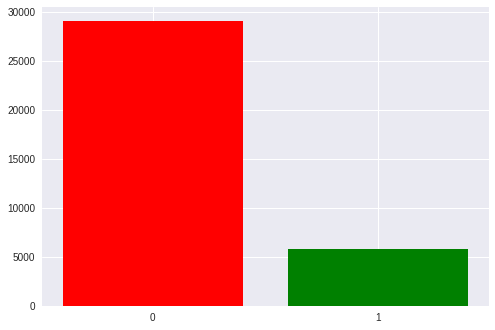

In [21]:
all_labels = np.concatenate([labels for _, labels in dataset])

uniques, counts = np.unique(all_labels, return_counts=True)

plt.bar(uniques, counts, color=['r', 'g'])
plt.xticks(uniques)

print(counts[0] / counts[1])

Теперь настало время взглянуть на отличие целевого сигнала от нецелевого

In [22]:
def plot_by_labels(epochs, labels):
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    for label in (0, 1):
        mean = epochs[labels == label].mean(axis=(0, 1))
        std = epochs[labels == label].std(axis=(0, 1))

        axes[0].plot(mean, label=captions[label])

        axes[1].plot(mean, label=captions[label])
        axes[1].fill_between(np.arange(mean.size), mean-std, mean+std, alpha=0.25)

    axes[0].legend(fontsize=20)
    axes[0].set_ylim(-0.16, 0.26)
    axes[1].set_ylim(-0.8, 0.85)
    for i, title in enumerate(('Means', 'Means with Stds')):
        axes[i].set_title(title, fontsize=20)
        axes[i].set_xticklabels(np.arange(-200, 1000, 200))
        axes[i].set_xlabel('milliseconds')

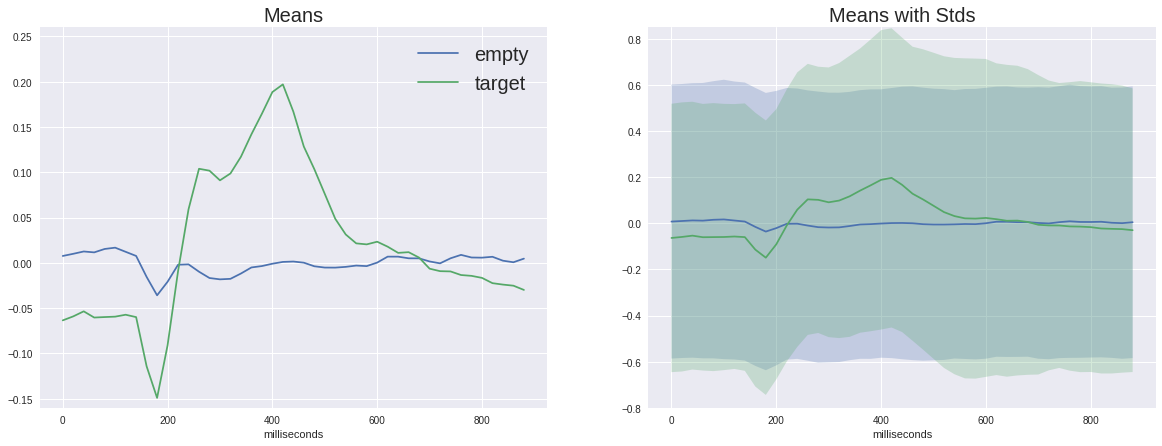

In [23]:
plot_by_labels(all_epochs, all_labels)

На левом графике можно увидеть, что средние сигналы разнятся очень сильно, причём у обоих есть неспецифический отклик в районе 180мс, но у целевого он гораздо амплитуднее, также у целевого есть характерный горб от 250 до 500 мс - это и есть пресловутый P300.

С таким отличием в сигнале наша задача может показаться плёвой, но если мы добавим на график стандартное отклонение в каждой точке, то увидим, что картина не так уж радужна - сигнал довольно сильно зашумлён. И это не смотря на то, что соотношение сигнал-шум для P300 считается одним из самых высоких в нейрофизиологии.

(На самом деле эти графики построены не вполне честно т.к. пустой сигнал усредняется по впятеро большему числу разных семплов, таким образом случайные отклонения давятся больше, но как мы видим по дисперсии одного порядка, это не слишком помогает)

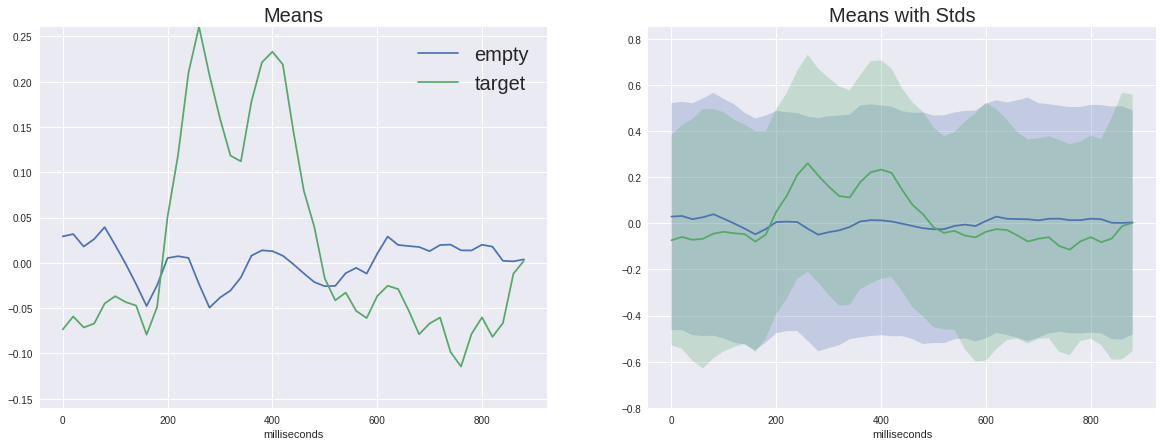

In [24]:
plot_by_labels(dataset[6][0], dataset[6][1])

Также полезно взглянуть на средние сигналы одного человека.

Тут находит подтвержедние предыдущая ремарка про "нечестное" усреднение - пустой сигнал заметно амплитуднее, чем при усреднении по всем. Также пик P300 у одного человека более высокий из-за меньшего усреднения.

Важно отметить ещё одну особенность сигнала одного человека - он имеет несколько другую форму, чем обобщённый. Межличностная вариативность нейрофизиологических реакций довольно высока, мы ещё увидим влияние этого фактора в работе классификаторов. Впрочем, внутриличностные различия (один человек в разном настроении, уровне стресса, усталости) также достаточно велика.

In [25]:
import visualizers

Subtracting Evoked from Epochs
[done]


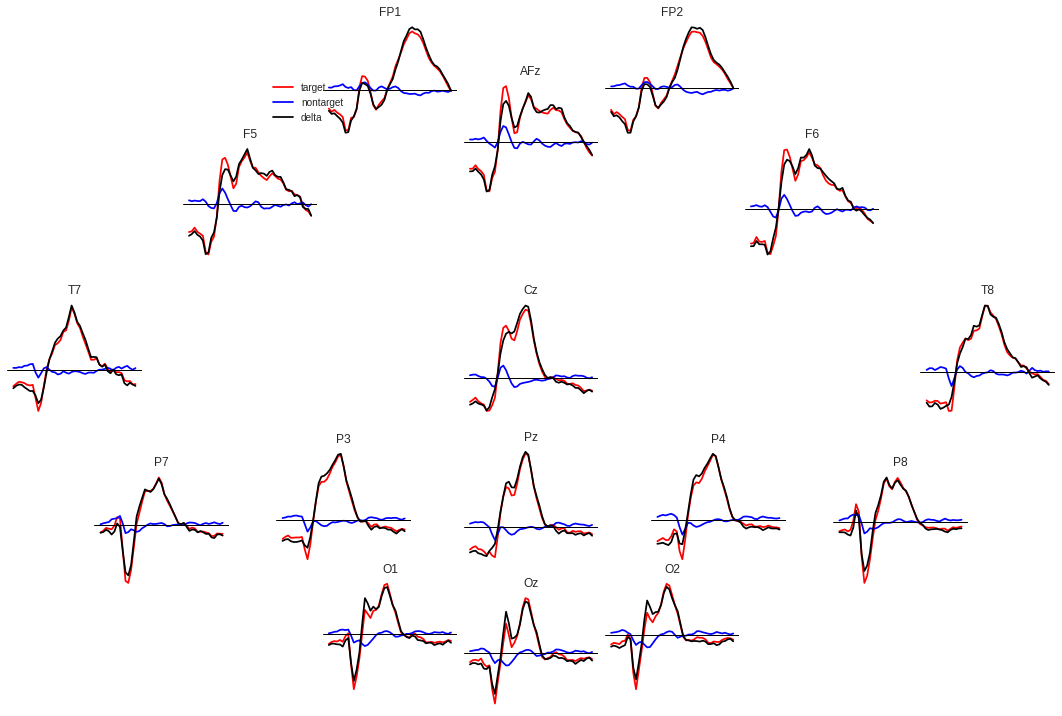

In [26]:
reload(visualizers)

visualizers.plot_evoked_electrodes(dataset, final_rate, channels)

Далее мы видим поканальную развёртку сигналов. Точка зрения тут совпадает с картинкой выше, на которой изображены положения электродов - нос сверху и т.д.

Отклик каждой части головы разный. На Fp1,2 ярко выражены два отрицательных пика, предшествующих положительному пику. Также в некоторых каналах положительных пика два, а в некоторых - один или что-то переходное между.

Разные каналы имеют разную важность для определения наличия P300, её можно оценить разными методами - вычислением взаимной информации (mutual information) или методом добавления-удаления (aka stepwise regression). Примененнием этих методов мы займёмся в другой раз.

Стоит помнить, что электродами мы измеряем разность потенциалов между электродами, а значит мы можем по измененрям напряжения в отдельных точках построить карту напряжений для всей головы в определённые моменты времени. Понятно, что при наличии 16 электродов точность такой карты оставляет желать лучшего, но какое-то понимание сформировать. (`mne` по умолчанию ожидает увидеть микровольты, но мы уже применили масштабирование, так что абсолютные величины указаны не верно)

Subtracting Evoked from Epochs
[done]


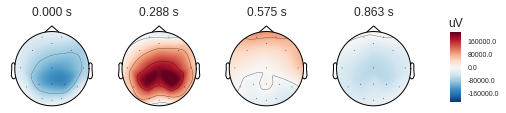

In [27]:
reload(visualizers)

visualizers.plot_evoked_map(dataset, final_rate, channels)

Subtracting Evoked from Epochs
[done]


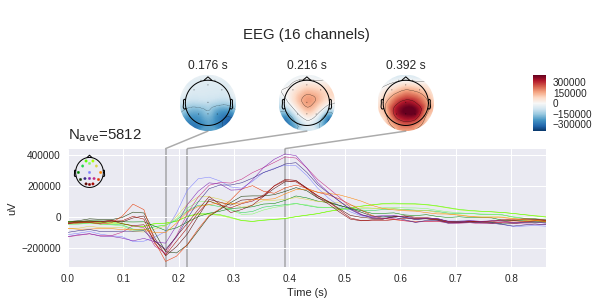

In [28]:
reload(visualizers)
    
visualizers.plot_evoked_joint(dataset, final_rate, channels)

## Классификация

Наконец пришло время применить методы машинного обучения к нашей выборке.

В качестве классификаторов были выбраны несколько базовых - лог. регрессия, метод опорных векторов (SVM) и несколько методов, использующих корреляционный анализ из пакета [`pyriemann`](https://github.com/alexandrebarachant/pyRiemann) (детали работы каждого метода можно найти в документации), стоит отметить, что эти методы специально разрабатывались для применения к ЭЭГ и с их помощью было выиграно [несколько](https://www.kaggle.com/c/inria-bci-challenge/discussion/12819#latest-91984) [соревнований](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/discussion/16479#latest-165271) на kaggle.

In [43]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from mne.decoding import Vectorizer, CSP

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

In [30]:
scores = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

In [31]:
# from https://eeg-notebooks.readthedocs.io/en/latest/visual_p300.html
# and https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html

clfs = {
    'LR': (
        make_pipeline(Vectorizer(), LogisticRegression()),
        {'logisticregression__C': np.exp(np.linspace(-4, 4, 9))},
    ),
    'LDA': (
        make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen')),
        {},
    ),
    'SVM': (
        make_pipeline(Vectorizer(), SVC()),
        {'svc__C': np.exp(np.linspace(-4, 4, 9))},
    ),
    'CSP LDA': (
        make_pipeline(CSP(), LDA(shrinkage='auto', solver='eigen')),
        {'csp__n_components': (6, 9, 13), 'csp__cov_est': ('concat', 'epoch')},
    ),
    'Xdawn LDA': (
        make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen')),
        {},
    ),
    'ERPCov TS LR': (
        make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression()),
        {'erpcovariances__estimator': ('lwf', 'oas')},
    ),
    'ERPCov MDM': (
        make_pipeline(ERPCovariances(), MDM()),
        {'erpcovariances__estimator': ('lwf', 'oas')},
    ),
}

In [39]:
def crossvalidate_record(record, clfs=clfs, scores=scores):
    df = pd.DataFrame()
    for name, (clf, params) in clfs.items():
        cv = GridSearchCV(
            clf,
            params,
            scoring=scores,
            n_jobs=-1,
            iid=False,
            refit=False,
            cv=4,
        )
        cv.fit(record[0], record[1])
        headers = [
            name for name in cv.cv_results_.keys()
                if name.startswith('param_') or name.startswith('mean_test_') or name.startswith('std_test_')
        ]
        results = pd.DataFrame(cv.cv_results_)[headers]
        results['cassifier'] = name
        df = pd.concat((df, results), sort=False)
    return df.reindex(sorted(df.columns), axis=1)

In [40]:
crossvalidate_record(dataset[0]).sort_values('mean_test_f1', ascending=False)

,cassifier,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc,param_csp__cov_est,param_csp__n_components,param_erpcovariances__estimator,param_logisticregression__C,param_svc__C,std_test_accuracy,std_test_f1,std_test_precision,std_test_recall,std_test_roc_auc
0,LDA,0.958720,0.869982,0.912620,0.834764,0.978623,NaN,NaN,NaN,NaN,NaN,0.005026,0.020563,0.027816,0.056663,0.011155
6,LR,0.954128,0.858877,0.884439,0.839141,0.967125,NaN,NaN,NaN,7.38906,NaN,0.007807,0.024955,0.046525,0.053487,0.020001
5,LR,0.954128,0.858276,0.888814,0.834596,0.967563,NaN,NaN,NaN,2.71828,NaN,0.007807,0.024557,0.050331,0.054296,0.019626
7,LR,0.953356,0.855507,0.883596,0.834428,0.966684,NaN,NaN,NaN,20.0855,NaN,0.010500,0.036666,0.046707,0.068689,0.020500
4,LR,0.953366,0.854803,0.890379,0.825505,0.967500,NaN,NaN,NaN,1,NaN,0.010233,0.032938,0.047688,0.053576,0.019333
3,LR,0.953361,0.854762,0.888503,0.825589,0.966568,NaN,NaN,NaN,0.367879,NaN,0.010037,0.032758,0.040918,0.048171,0.019330
8,LR,0.952590,0.854107,0.876278,0.838973,0.966246,NaN,NaN,NaN,54.5982,NaN,0.011601,0.039983,0.050892,0.073885,0.020909
0,Xdawn LDA,0.948002,0.836727,0.876971,0.802609,0.976279,NaN,NaN,NaN,NaN,NaN,0.014884,0.049118,0.056402,0.062290,0.011152
2,LR,0.947254,0.832824,0.882602,0.793434,0.964386,NaN,NaN,NaN,0.135335,NaN,0.014897,0.050138,0.058636,0.074598,0.020655
0,ERPCov TS LR,0.946469,0.831684,0.871476,0.797980,0.977800,NaN,NaN,lwf,NaN,NaN,0.005650,0.022951,0.025388,0.050809,0.004717


Наиболее часто встречающаяся схема нейроинтерфейсов это "калибровка+работа" т.е. сначала нужно, чтобы человек какое-то время концентрировался на заранее указанных стимулах и только после этого мы предсказываем его выбор. Этот подход обладает очевидным минусом занудого начального этапа.

Для оценки работоспособности наших методов в этом режиме проведём кроссвалидацию внутри эпох одного человека.
Метрика accuracy в данном случае не релевантна в силу разбалансированности датасета (бейзлайн тут 5/6 ~ 83%), так что я предпочитаю смотреть на тройку precision-recall-f1.

Чтобы обозреть весь датасет, усредним результаты такой кроссвалидации по всем людям. В целом, перфоманс лучших моделей достаточно высок по сравнению с тем, что мы в [Neiry](https://impulse-neiry.com/) имеем в "полевых" условиях парка развлечений (напомню, что этот датасет записывался в лаборатории).

В этом датасете присутствуют только бинарные метки для данных. В целом же нам нужно решить мультиклассовую задачу выбора одного из стимулов (она, кстати, сбалансирована т.к. каждый стимул активируется одиаковое количество раз). Для её решения обычно фиксируют число активаций каждого стимула (например, 6 стимулов по 5 активаций) и все стимулы в случайном порядке активируются (30 раз), получается 30 эпох и для каждого стимула складываются вероятности его активаций быть целевыми, после этого стимул, набравший максимальную сумму признаётся целевым. Релизацию этого подхода мы продемонстрируем в одном из будущих постов на подходящем датасете.

In [41]:
def crossvalidate_dataset(dataset, clfs=clfs, scores=scores):
    res = {name: [] for name in scores}
    for record in dataset:
        df = crossvalidate_record(record, clfs, scores)
        for name in scores:
            res[name].append(df[f'mean_test_{name}'])

    final = df.copy()
    for name, values in res.items():
        values = np.array(values)
        final[f'mean_test_{name}'] = values.mean(axis=0)
        final[f'std_test_{name}'] = values.std(axis=0)
    return final.sort_values('mean_test_f1', ascending=False)

In [42]:
crossvalidate_dataset(dataset)

,cassifier,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc,param_csp__cov_est,param_csp__n_components,param_erpcovariances__estimator,param_logisticregression__C,param_svc__C,std_test_accuracy,std_test_f1,std_test_precision,std_test_recall,std_test_roc_auc
0,LDA,0.923740,0.755187,0.807938,0.714048,0.937733,NaN,NaN,NaN,NaN,NaN,0.026188,0.088218,0.079014,0.096762,0.037033
0,Xdawn LDA,0.916701,0.724430,0.789652,0.675967,0.929576,NaN,NaN,NaN,NaN,NaN,0.030635,0.113420,0.087832,0.130440,0.042307
1,ERPCov TS LR,0.915442,0.717535,0.803442,0.656063,0.934828,NaN,NaN,oas,NaN,NaN,0.027672,0.098960,0.084396,0.106212,0.035510
4,LR,0.908585,0.714396,0.749877,0.688541,0.925202,NaN,NaN,NaN,1,NaN,0.028895,0.090115,0.090134,0.094837,0.041020
3,LR,0.910585,0.713458,0.766201,0.674487,0.927167,NaN,NaN,NaN,0.367879,NaN,0.027800,0.092060,0.085299,0.101712,0.039063
0,ERPCov TS LR,0.914804,0.712915,0.802924,0.648123,0.933822,NaN,NaN,lwf,NaN,NaN,0.027276,0.100450,0.084851,0.110476,0.036658
5,LR,0.905771,0.709680,0.735692,0.691252,0.922693,NaN,NaN,NaN,2.71828,NaN,0.031073,0.093074,0.097099,0.093453,0.042668
2,LR,0.911547,0.706163,0.783485,0.651868,0.926304,NaN,NaN,NaN,0.135335,NaN,0.025266,0.093878,0.071508,0.111847,0.038012
6,LR,0.902927,0.704557,0.722633,0.692869,0.920636,NaN,NaN,NaN,7.38906,NaN,0.033362,0.097128,0.103715,0.094821,0.043746
7,LR,0.901106,0.701588,0.713840,0.695245,0.918897,NaN,NaN,NaN,20.0855,NaN,0.033701,0.096868,0.104253,0.093595,0.044600


Вторая схема проведения называется transfer learning - то есть перенос классификатора между людьми. Дело в том, что когда мы делаем калибровку, то мы фактически переобучаемся на форму пика одного человека, поэтому можем неплохо предсказывать её же в последующих тестах. В случае отсутствия калибровки, предобученный классификатор должен уметь выделять концепцию P300 не зная наперёд форму сигнала конкретного человека.

Мы проведём два эксперимента - обучим классификатор на одном человеке, и предскажем пятерых, а потом увеличим тренировочную выборку до 10 человек и сравним результаты чтобы убедиться, что модели смогли повысить свою обобщающую способность

In [56]:
def transfer_validate(train_records: list, val_records: list, clfs=clfs, scores=scores):
    df = pd.DataFrame()
    
    train_epochs = np.concatenate([epochs for epochs, _ in train_records])
    train_labels = np.concatenate([labels for _, labels in train_records])
    val_epochs = np.concatenate([epochs for epochs, _ in val_records])
    val_labels = np.concatenate([labels for _, labels in val_records])
    splitter = PredefinedSplit([-1] * len(train_labels) + [0] * len(val_labels))
    epochs = np.concatenate((train_epochs, val_epochs))
    labels = np.concatenate((train_labels, val_labels))

    for name, (clf, params) in clfs.items():
        cv = GridSearchCV(
            clf,
            params,
            scoring=scores,
            n_jobs=-1,
            iid=False,
            refit=False,
            cv=splitter,
        )
        cv.fit(epochs, labels)
        headers = [
            name for name in cv.cv_results_.keys()
                if name.startswith('param_') or name.startswith('mean_test_') or name.startswith('std_test_')
        ]
        results = pd.DataFrame(cv.cv_results_)[headers]
        results['cassifier'] = name
        df = pd.concat((df, results), sort=False)
    return df.reindex(sorted(df.columns), axis=1)

In [58]:
transfer_validate(dataset[:1], dataset[10:15])

,cassifier,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc,param_csp__cov_est,param_csp__n_components,param_erpcovariances__estimator,param_logisticregression__C,param_svc__C,std_test_accuracy,std_test_f1,std_test_precision,std_test_recall,std_test_roc_auc
0,LR,0.834426,0.233881,0.511050,0.151639,0.711602,NaN,NaN,NaN,0.0183156,NaN,0.0,0.0,0.0,0.0,0.0
1,LR,0.835656,0.212181,0.527687,0.132787,0.719348,NaN,NaN,NaN,0.0497871,NaN,0.0,0.0,0.0,0.0,0.0
2,LR,0.836749,0.203864,0.544484,0.125410,0.721404,NaN,NaN,NaN,0.135335,NaN,0.0,0.0,0.0,0.0,0.0
3,LR,0.835519,0.201592,0.527778,0.124590,0.719455,NaN,NaN,NaN,0.367879,NaN,0.0,0.0,0.0,0.0,0.0
4,LR,0.835656,0.209073,0.528239,0.130328,0.716132,NaN,NaN,NaN,1,NaN,0.0,0.0,0.0,0.0,0.0
5,LR,0.835383,0.213960,0.523962,0.134426,0.712814,NaN,NaN,NaN,2.71828,NaN,0.0,0.0,0.0,0.0,0.0
6,LR,0.833880,0.210390,0.506250,0.132787,0.710186,NaN,NaN,NaN,7.38906,NaN,0.0,0.0,0.0,0.0,0.0
7,LR,0.833333,0.212903,0.500000,0.135246,0.708162,NaN,NaN,NaN,20.0855,NaN,0.0,0.0,0.0,0.0,0.0
8,LR,0.832104,0.210662,0.486647,0.134426,0.706610,NaN,NaN,NaN,54.5982,NaN,0.0,0.0,0.0,0.0,0.0
0,LDA,0.840984,0.195021,0.623894,0.115574,0.754377,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [59]:
transfer_validate(dataset[:10], dataset[10:15])

,cassifier,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc,param_csp__cov_est,param_csp__n_components,param_erpcovariances__estimator,param_logisticregression__C,param_svc__C,std_test_accuracy,std_test_f1,std_test_precision,std_test_recall,std_test_roc_auc
0,LR,0.861885,0.400711,0.723769,0.277049,0.842113,NaN,NaN,NaN,0.0183156,NaN,0.0,0.0,0.0,0.0,0.0
1,LR,0.866393,0.438576,0.731801,0.313115,0.846606,NaN,NaN,NaN,0.0497871,NaN,0.0,0.0,0.0,0.0,0.0
2,LR,0.867760,0.458613,0.721831,0.336066,0.847314,NaN,NaN,NaN,0.135335,NaN,0.0,0.0,0.0,0.0,0.0
3,LR,0.867896,0.465451,0.714771,0.345082,0.846306,NaN,NaN,NaN,0.367879,NaN,0.0,0.0,0.0,0.0,0.0
4,LR,0.866530,0.465244,0.700165,0.348361,0.845156,NaN,NaN,NaN,1,NaN,0.0,0.0,0.0,0.0,0.0
5,LR,0.866940,0.467760,0.701639,0.350820,0.844264,NaN,NaN,NaN,2.71828,NaN,0.0,0.0,0.0,0.0,0.0
6,LR,0.866940,0.468341,0.700980,0.351639,0.843696,NaN,NaN,NaN,7.38906,NaN,0.0,0.0,0.0,0.0,0.0
7,LR,0.866393,0.467320,0.696429,0.351639,0.843334,NaN,NaN,NaN,20.0855,NaN,0.0,0.0,0.0,0.0,0.0
8,LR,0.866393,0.467320,0.696429,0.351639,0.843084,NaN,NaN,NaN,54.5982,NaN,0.0,0.0,0.0,0.0,0.0
0,LDA,0.869262,0.458404,0.740402,0.331967,0.852494,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


Итак f1 поднялся с 0.23 до 0.4 для лучшего классификатора (в обоих случаях это логрегрессия с одинаковой регуляризацией).

Это означает, что предсказательная способность повысилась от "никакой" до "приемлемой". Исходя из нашего опыта при таких метриках бинарной задачи достаточно 5 активаций каждого стимула, для достижения accuracy мультиклассовой задачи около 75%.

В конце хочется отметить, что приведённый метод достаточно примитивен, что видно, например, по высокой степени регуляризации логрегрессии - каналы в данных довольно сильно скореллированы и существует несколько подходов к разрешению этого обстоятельства.

## Заключение

Сегодня мы ближе познакомились с вызванным потенциалом P300 и построили простой пайплайн для нейроинтерфейса. Рекомендую заинтересовавшимся самостоятельно открыть ноутбук (находится в [репозитории](https://gitlab.com/impulse-neiry_public/posts)) и поэкспериментировать с вариантами визуализаций и классификаторов.

Имея базовое представление о методах работы с сигналом ЭЭГ мы в дальнейшем сможем более глубоко рассмотреть эту тему - применить продвинутые методы предобработки, а также нейросети для решения задач построения нейроинтерфейсов. Продолжение следует...